#### Friday, March 29, 2024

Re-running again ... This all runs in one pass. 

#### Thursday, March 21, 2024

Re-running again ... 

#### Friday, March 15, 2024

Using the 't4nlpacv' environment. 

* mamba install conda-forge::accelerate

This all runs in one pass.

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# Run Date: Friday, March 29, 2024
# Run Time: 00:01:26

# How to train a new language model from scratch using Transformers and Tokenizers

Copyright 2023, Denis Rothman. Denis Rothman adapted a Hugging Face reference notebook to pretrain a transformer model. In 2023, a hardware accelerator was added.

It is recommended to understand this notebook. The emergence of GPT-3 engines has produced an API that can outperform many trained transformers models. However, to show a transformer what to do with the input datasets, it is essential to understand how they are trained.

The Transformer model of this notebook is a Transformer model named ***KantaiBERT***. ***KantaiBERT*** is trained as a RoBERTa Transformer with DistilBERT architecture. The dataset was compiled from three books by Immanuel Kant downloaded from the [Gutenberg Project](https://www.gutenberg.org/).


***KantaiBERT*** was pretrained with a small model of 84 million parameters using the same number of layers and heads as DistilBert, i.e., 6 layers, 768 hidden size,and 12 attention heads. ***KantaiBERT*** is then fine-tuned for a downstream masked Language Modeling task.

### The Hugging Face original Reference and notes:

Notebook edition (link to original of the reference blogpost [link](https://huggingface.co/blog/how-to-train)).


#Step 1: Loading the dataset

In [2]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [3]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name):

    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/06/'

    # Make the request
    response = requests.get(base_url + image_name)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [4]:
#1.Load kant.txt using the Colab file manager
#2.Downloading the file from GitHub
# !curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter06/kant.txt --output "kant.txt"

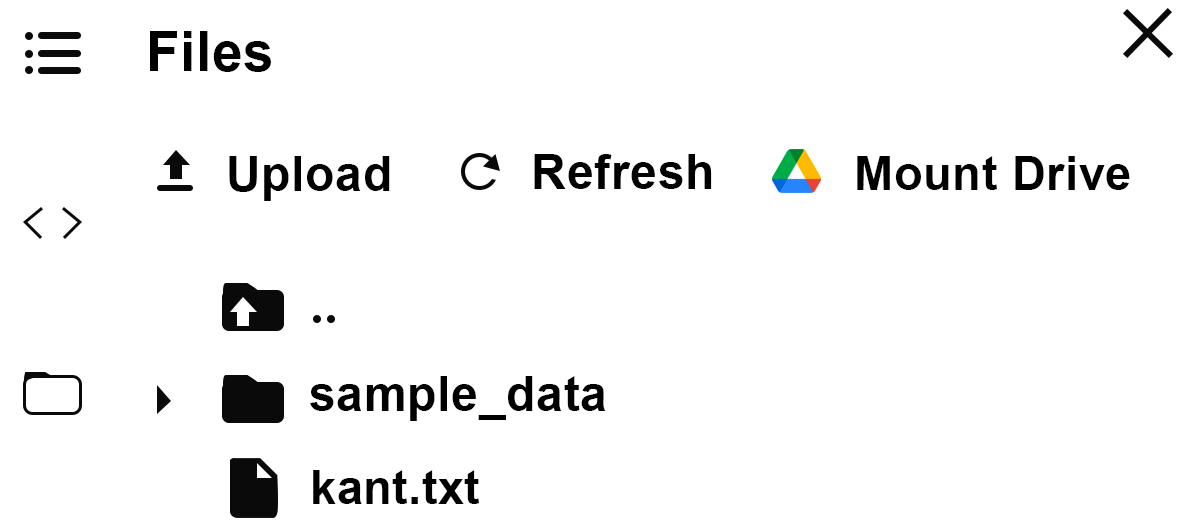

In [5]:
display(get_image_from_github('B19899_06_01.png') or print('Image not found'))

#Step 2: Installing Hugging Face transformers

April 2023 update From Hugging Face Issue 22816:

https://github.com/huggingface/transformers/issues/22816

"The PartialState import was added as a dependency on the transformers development branch yesterday. PartialState was added in the 0.17.0 release in accelerate, and so for the development branch of transformers, accelerate >= 0.17.0 is required.

Downgrading the transformers version removes the code which is importing PartialState."

Denis Rothman: The following cell imports the latest version of Hugging Face transformers but without downgrading it.

To adapt to the Hugging Face upgrade, A GPU accelerator was activated using the Google Colab Pro with the following NVIDIA GPU:
GPU Name: NVIDIA A100-SXM4-40GB

In [6]:
# only target the 4090 ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# !pip install Transformers
# !pip install --upgrade accelerate
from accelerate import Accelerator

/home/rob/miniforge3/envs/t4nlpacv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


/home/rob/miniforge3/envs/t4nlpacv/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#Step 3: Training a tokenizer

In [8]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

In [9]:
paths = [str(x) for x in Path(".").glob("**/*.txt")]

In [10]:
paths

['kant.txt', 'KantaiBERT/merges.txt']

In [11]:
# We really only want the first file, so force this ...
del paths[-1]
paths

['kant.txt']

In [12]:
# Read the content from the files, ignoring or replacing invalid characters
file_contents = []
for path in paths:
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as file:
            file_contents.append(file.read())
    except Exception as e:
        print(f"Error reading {path}: {e}")

In [13]:
len(file_contents[0])

11230501

In [14]:
!ls -l kant.txt

-rw-rw-r-- 1 rob rob 11258065 Mar 15 07:30 kant.txt


In [15]:

# Join the contents into a single string
text = "\n".join(file_contents)

In [16]:
len(text)

11230501

In [17]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

In [18]:
# I am gonna set the vocab_size here because we need to set it further down when creating the model ...
# ... does stuff blow up if we set a different value??
vocab_size = 52_000

In [19]:
# Customize training
tokenizer.train_from_iterator([text], vocab_size=vocab_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

# 3.4s

#Step 4: Saving the files to disk

In [20]:
kantaiBERT = 'KantaiBERT'

In [21]:
import os
# token_dir = './content/KantaiBERT'
token_dir = kantaiBERT

In [22]:
token_dir

'KantaiBERT'

In [23]:
if not os.path.exists(token_dir):
  os.makedirs(token_dir)

In [24]:
# tokenizer.save_model('KantaiBERT')
tokenizer.save_model(token_dir)

['KantaiBERT/vocab.json', 'KantaiBERT/merges.txt']

In [25]:
!ls -l KantaiBERT/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 326720
-rw-rw-r-- 1 rob rob       636 Mar 29 13:55 config.json
-rw-rw-r-- 1 rob rob    192981 Mar 29 14:24 merges.txt
-rw-rw-r-- 1 rob rob 334030264 Mar 29 13:55 model.safetensors
-rw-rw-r-- 1 rob rob      4536 Mar 29 13:55 training_args.bin
-rw-rw-r-- 1 rob rob    318435 Mar 29 14:24 vocab.json


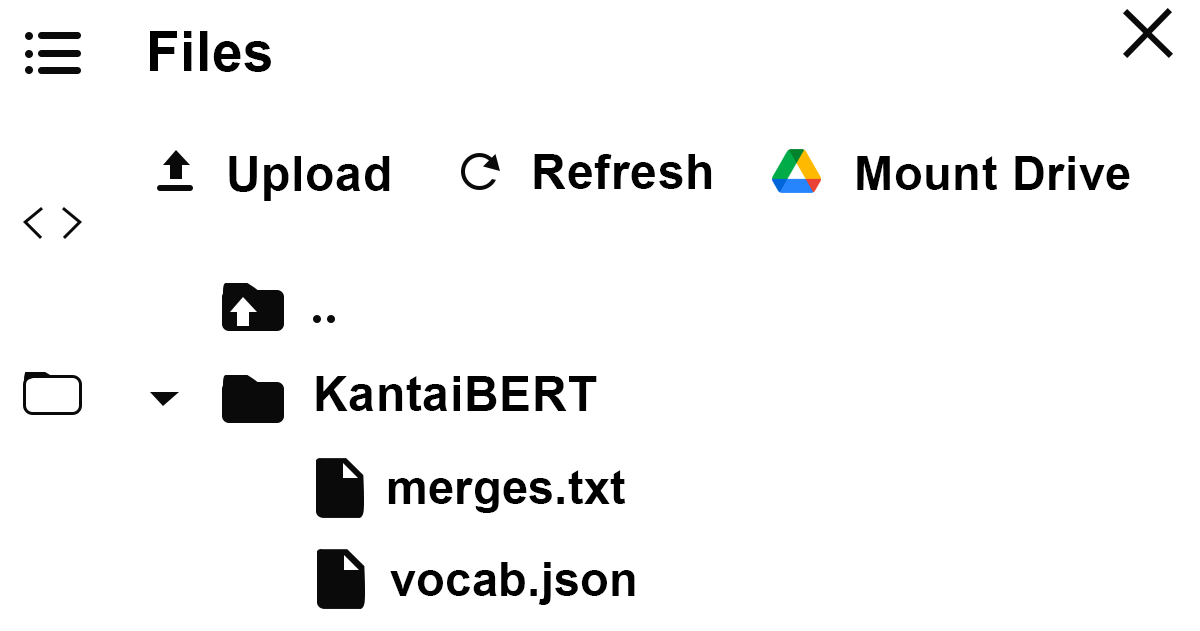

In [26]:
display(get_image_from_github('B19899_06_02.png') or print('Image not found'))

#Step 5: Loading the trained tokenizer files

In [27]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# tokenizer = ByteLevelBPETokenizer(
#     "./KantaiBERT/vocab.json",
#     "./KantaiBERT/merges.txt",
# )

tokenizer = ByteLevelBPETokenizer(
    kantaiBERT + "/vocab.json",
    kantaiBERT + "/merges.txt",
)

In [28]:
tokenizer.encode("The Critique of Pure Reason.").tokens

['The', 'ĠCritique', 'Ġof', 'ĠPure', 'ĠReason', '.']

In [29]:
tokenizer.encode("The Critique of Pure Reason.")

Encoding(num_tokens=6, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [30]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

#Step 6: Checking Resource Constraints: GPU and NVIDIA

In [31]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Mar 29 14:24:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P0              N/A /  70W |    170MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [32]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

True

#Step 7: Defining the configuration of the model

In [33]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [34]:
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



#Step 8: Reloading the tokenizer in transformers

In [35]:
from transformers import RobertaTokenizer
# tokenizer = RobertaTokenizer.from_pretrained("./KantaiBERT", max_length=512)
tokenizer = RobertaTokenizer.from_pretrained(kantaiBERT, max_length=512)

#Step 9: Initializing a model from scratch

In [ ]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print(model)

## Exploring the parameters

In [37]:
print(model.num_parameters())

83504416


In [ ]:
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

In [ ]:
#Shape of each tensor in the model
LP = list(model.parameters())
for i, tensor in enumerate(LP):
    print(f"Shape of tensor {i}: {tensor.shape}")

In [ ]:
#counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

#Step 10: Building the dataset

In [41]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./kant.txt",
    block_size=128,
)

/home/rob/miniforge3/envs/t4nlpacv/lib/python3.11/site-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


CPU times: user 11.9 s, sys: 166 ms, total: 12.1 s
Wall time: 11.7 s


#Step 11: Defining a data collator

In [42]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

#Step 12: Initializing the trainer

In [43]:
from transformers import Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./KantaiBERT",
#     overwrite_output_dir=True,
#     num_train_epochs=1, #can be increased
#     per_device_train_batch_size=64,
#     save_steps=10_000,
#     save_total_limit=2,
# )

training_args = TrainingArguments(
    output_dir=kantaiBERT,
    overwrite_output_dir=True,
    num_train_epochs=1, #can be increased
    # per_device_train_batch_size=64,
    per_device_train_batch_size=256,
    save_steps=10_000,
    save_total_limit=2,
)



In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

/home/rob/miniforge3/envs/t4nlpacv/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


#Step 13: Pretraining the model

In [45]:
%%time
trainer.train()

# 1m 4.8s per_device_train_batch_size=256 VRAM 15766 MiB

# 1m 34.6s per_device_train_batch_size=64
# 1m 32.7s per_device_train_batch_size=64

Step,Training Loss
500,6.310500


CPU times: user 1min 5s, sys: 932 ms, total: 1min 6s
Wall time: 1min 3s


TrainOutput(global_step=668, training_loss=6.1473512021367425, metrics={'train_runtime': 63.5689, 'train_samples_per_second': 2689.429, 'train_steps_per_second': 10.508, 'total_flos': 929266538064384.0, 'train_loss': 6.1473512021367425, 'epoch': 1.0})

#Step 14: Saving the final model (+tokenizer + config) to disk

In [46]:
# trainer.save_model("./KantaiBERT")
trainer.save_model(kantaiBERT)

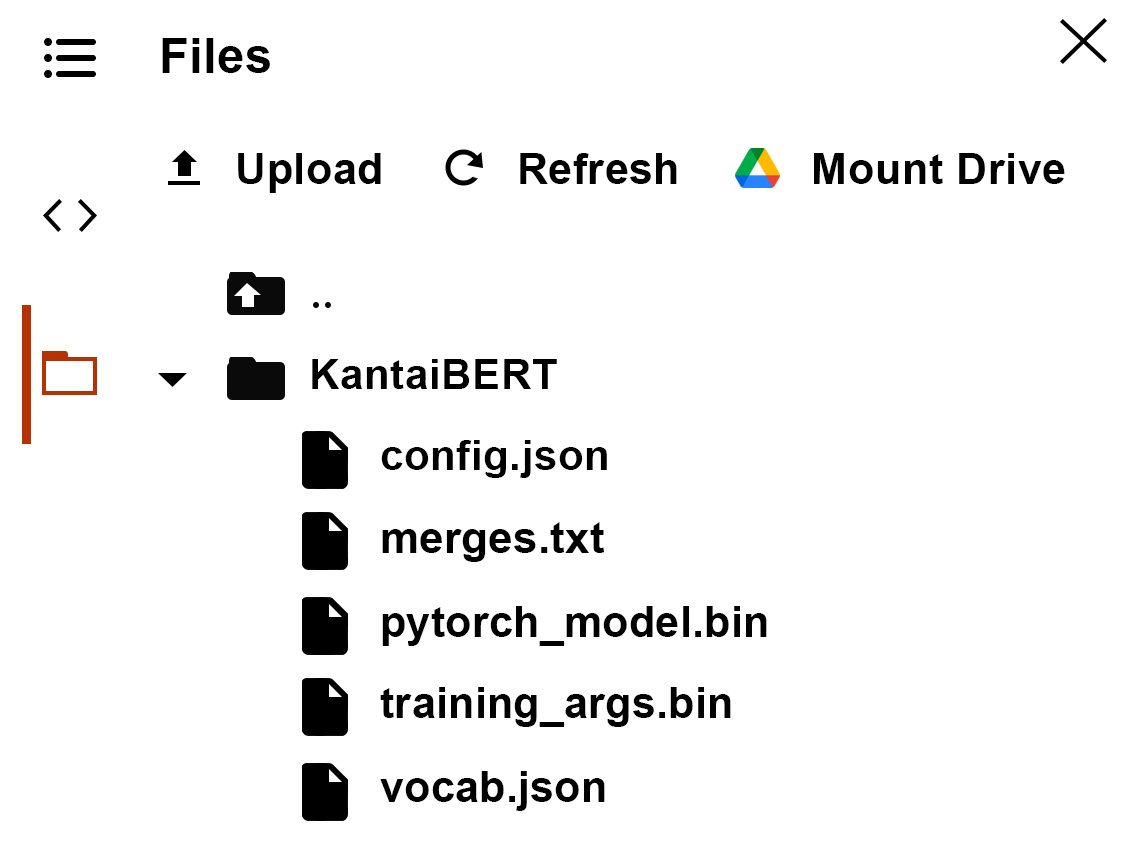

In [47]:
# display(get_image_from_github('B17948_06_05.png') or print('Image not found'))
display(get_image_from_github('B19899_06_05.png') or print('Image not found'))

In [48]:
# notice there is no pytorch_model.bin, but a model.safetensors
!ls -l KantaiBERT/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 326724
-rw-rw-r-- 1 rob rob       636 Mar 29 14:26 config.json
-rw-rw-r-- 1 rob rob    192981 Mar 29 14:24 merges.txt
-rw-rw-r-- 1 rob rob 334030264 Mar 29 14:26 model.safetensors
-rw-rw-r-- 1 rob rob      4536 Mar 29 14:26 training_args.bin
-rw-rw-r-- 1 rob rob    318435 Mar 29 14:24 vocab.json


#Step 15: Language modeling with FillMaskPipeline

In [49]:
from transformers import pipeline

# fill_mask = pipeline(
#     "fill-mask",
#     model="./KantaiBERT",
#     tokenizer="./KantaiBERT"
# )

fill_mask = pipeline(
    "fill-mask",
    model=kantaiBERT,
    tokenizer=kantaiBERT
)

In [50]:
fill_mask("Human thinking involves human <mask>.")

[{'score': 0.023184312507510185,
  'token': 267,
  'token_str': ' the',
  'sequence': 'Human thinking involves human the.'},
 {'score': 0.01582431048154831,
  'token': 270,
  'token_str': ' of',
  'sequence': 'Human thinking involves human of.'},
 {'score': 0.015330150723457336,
  'token': 18,
  'token_str': '.',
  'sequence': 'Human thinking involves human..'},
 {'score': 0.011828972958028316,
  'token': 488,
  'token_str': ' The',
  'sequence': 'Human thinking involves human The.'},
 {'score': 0.01153167150914669,
  'token': 263,
  'token_str': ' a',
  'sequence': 'Human thinking involves human a.'}]

In [51]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Mar 29 14:26:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P0              N/A /  70W |    170MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Friday, March 29, 2024
# Run Time: 00:01:27
